### Importing Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as pt
import warnings
warnings.filterwarnings('ignore')

### Reading the data

In [ ]:
df = pd.read_csv('multiTimeline.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.head()

,Month,Heater,Air conditioner
0,2005-01-01,6,10
1,2005-02-01,4,10
2,2005-03-01,3,12
3,2005-04-01,3,15
4,2005-05-01,3,24


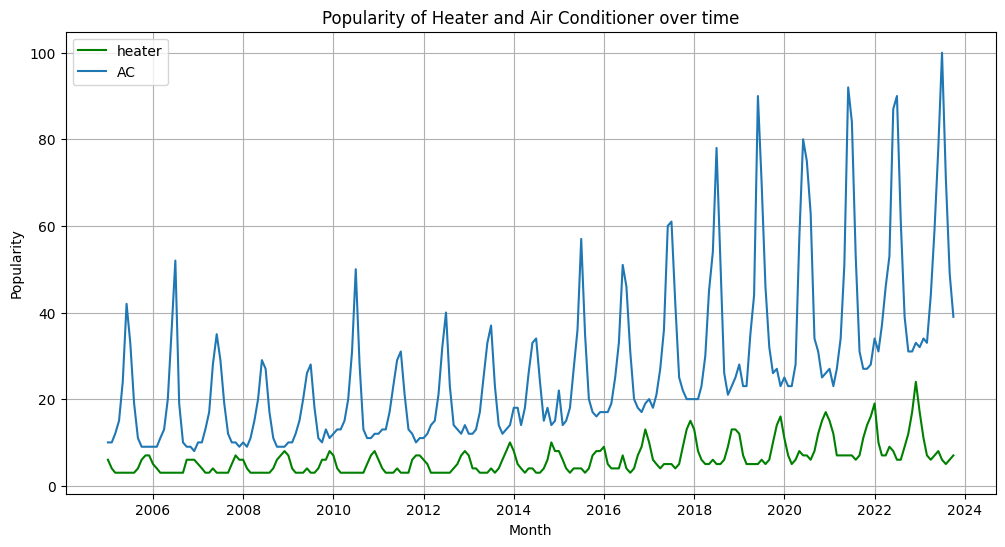

In [ ]:
# 2 time series plot , 1 for heater, the other for AC use plt.plot(), add legends
fig = plt.figure(figsize=(12,6))
plt.plot(df['Month'], df['Heater'], label='heater', color = 'green')
plt.plot(df['Month'], df['Air conditioner'], label='AC')
plt.title('Popularity of Heater and Air Conditioner over time')
plt.xlabel('Month')
plt.ylabel('Popularity')
plt.legend()
plt.grid()
plt.show()


In [ ]:
n = len(df['Month']) # number of observations
d = 12 # seasonality is 12 months
q = d//2
print(n,d,q)

226 12 6


### Estimating Trend and Seasonal Components

#### Parametric : Multiple Linear Regression

In [ ]:
# Preparing the design matrix
m = np.array([np.ones(len(df)), (df.index.values+1)]).T
s = np.array([np.sin(np.pi*(df.index.values+1)/q), np.cos(np.pi*(df.index.values+1)/q)]).T
m_s = np.hstack((m, s))

coefficients_heater = np.linalg.inv(m_s.T @ m_s) @ m_s.T @ df['Heater']
coefficients_AC = np.linalg.inv(m_s.T @ m_s) @ m_s.T @ df['Air conditioner']

# Predicting the values
y_hat_heater = m_s @ coefficients_heater
y_hat_AC = m_s @ coefficients_AC

Parametric Fitting

In [ ]:
# results for heater
# coefficients
print('Coefficients for heater: ', coefficients_heater.round(2))
# rmse
mse_heater = np.mean((df['Heater'] - y_hat_heater)**2)
rmse_heater = np.sqrt(mse_heater)
print('RMSE for heater: ', rmse_heater.round(2))

# results for AC
# coefficients
print('Coefficients for AC: ', coefficients_AC.round(2))
# rmse
mse_AC = np.mean((df['Air conditioner'] - y_hat_AC)**2)
rmse_AC = np.sqrt(mse_AC)
print('RMSE for AC: ', rmse_AC.round(2))

Coefficients for heater:  [ 2.68  0.03 -0.16  2.99]
RMSE for heater:  2.01
Coefficients for AC:  [  8.12   0.16  -3.4  -15.04]
RMSE for AC:  10.08


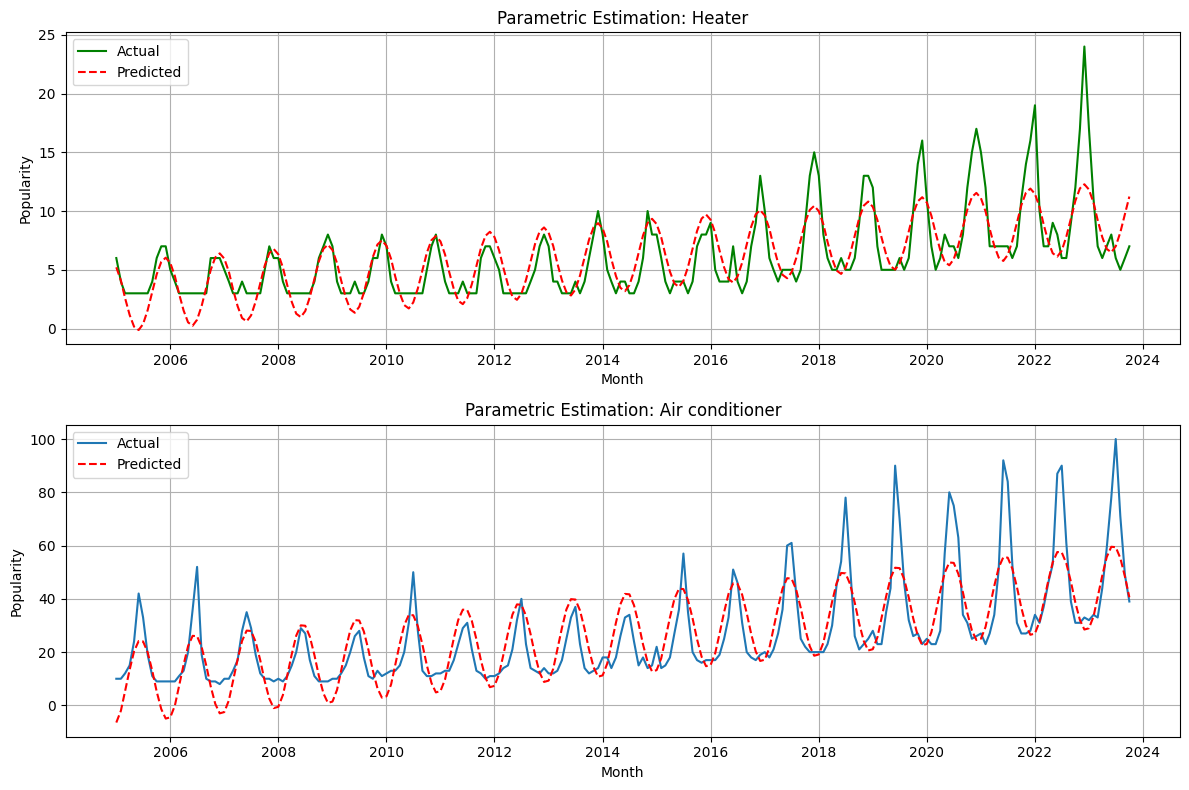

In [ ]:
# Plots of actual and predicted values
fig, axes = plt.subplots(2,1, figsize=(12,8))
axes[0].plot(df['Month'], df['Heater'], label='Actual', color='green')
axes[0].plot(df['Month'], y_hat_heater, label='Predicted', color='red', linestyle='--')
axes[0].set_title('Parametric Estimation: Heater')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Popularity')
axes[0].legend()
axes[0].grid()

axes[1].plot(df['Month'], df['Air conditioner'], label='Actual')
axes[1].plot(df['Month'], y_hat_AC, label='Predicted', color = 'red', linestyle='--')
axes[1].set_title('Parametric Estimation: Air conditioner')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Popularity')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

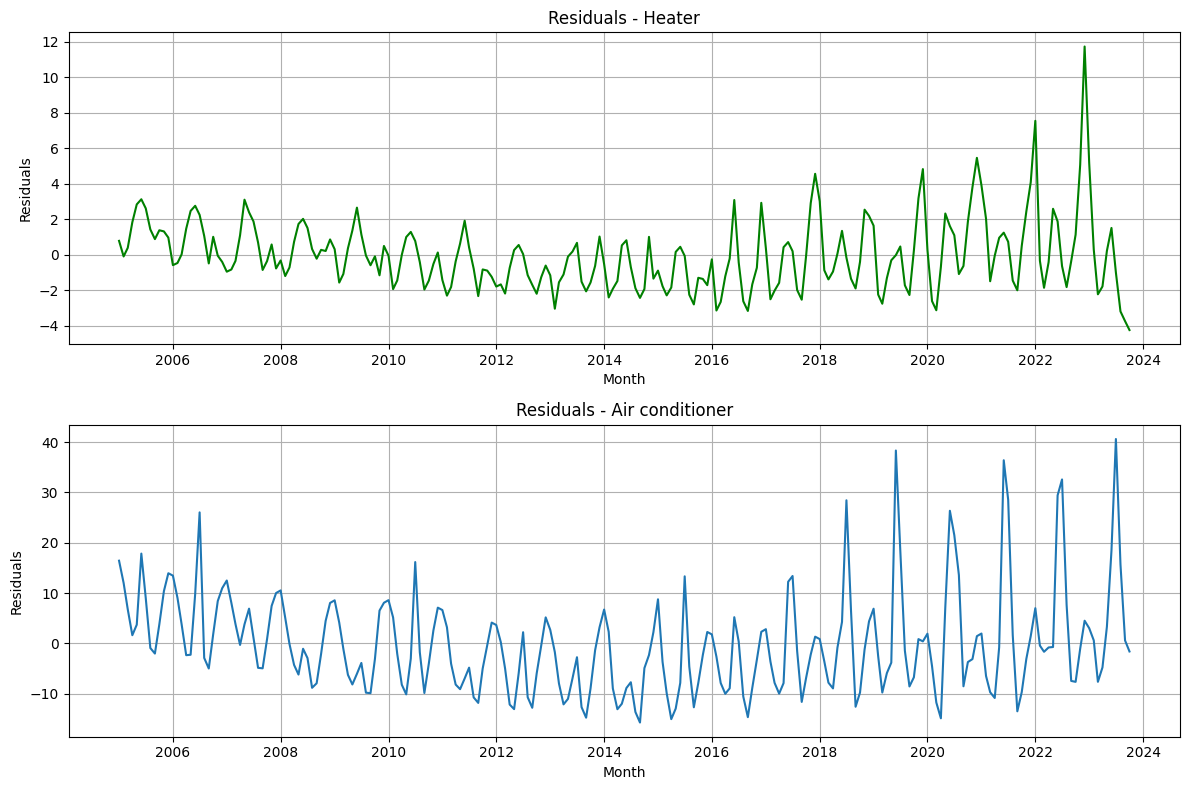

In [ ]:
# Plot of Residuals
fig, axes = plt.subplots(2,1, figsize=(12,8))
axes[0].plot(df['Month'], df['Heater'] - y_hat_heater, color='green')
axes[0].set_title('Residuals - Heater')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Residuals')
axes[0].grid()

axes[1].plot(df['Month'], df['Air conditioner'] - y_hat_AC)
axes[1].set_title('Residuals - Air conditioner')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Residuals')
axes[1].grid()

plt.tight_layout()
plt.show()

We can see that there is still a trend and seasonality remaining in the residuals

#### Non Parametric: Moving Average Filter

Estimating Trend and Seasonal Components

In [ ]:
# Function that estimates ma_filter
def ma_filter(t, Y, d):
  q = int(d/2)
  n = len(Y)

  if t<q or t>n-1-q:
    return 0

  m = 0.5*Y[t-q] + 0.5*Y[t+q]

  for i in range(1, 2*q):
    m += Y[t - q + i]

  return m/d

# Function that estimates weights
def wk(k, Y, d):
  k = k%d
  n = len(Y)
  q = d/2
  s = 0
  count = 0
  for j in range(0, n):
    if q <= k+j*d <= n-1-q:
      count += 1
      s += Y[k + j * d] - ma_filter(k + j * d, Y, d)
  if count == 0:
    return 0
  return float(s / count)

In [ ]:
# Estimating Trend mk_h for heater
m_k_h = []
for k in range(0, n):
    m_k_h.append(ma_filter(k, df['Heater'], d))
m_k_h = np.array(m_k_h)

# Estimating Trend mk_ac for AC
m_k_ac = []
for k in range(0, n):
    m_k_ac.append(ma_filter(k, df['Air conditioner'], d))
m_k_ac = np.array(m_k_ac)

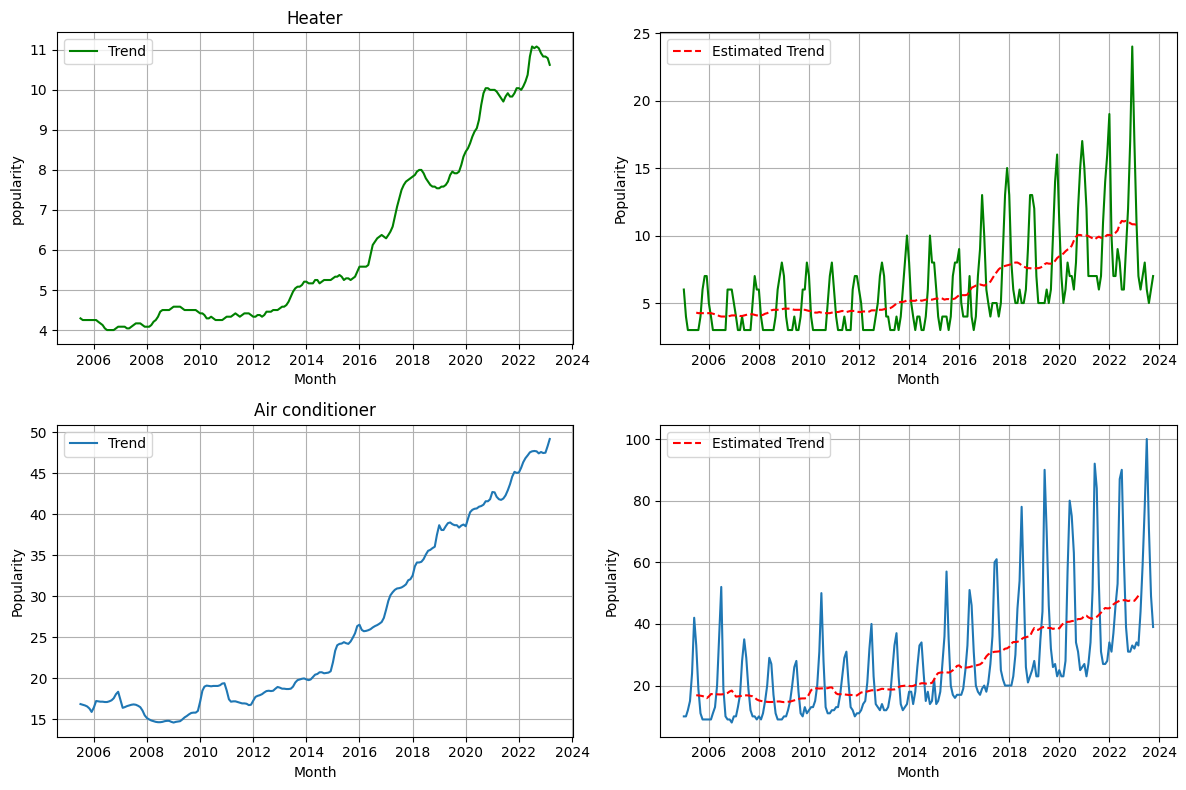

In [ ]:
# Plotting Trend
fig, axes = plt.subplots(2,2, figsize=(12,8))
axes[0,0].plot(df['Month'][q:n-q-1], m_k_h[q:n-q-1], color='green', label='Trend')
axes[0,0].set_title('Heater')
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('popularity')
axes[0,0].grid()
axes[0,0].legend()

axes[0,1].plot(df['Month'], df['Heater'], color='green')
axes[0,1].plot(df['Month'][q:n-q-1], m_k_h[q:n-q-1], color='red', linestyle='--', label= 'Estimated Trend')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Popularity')
axes[0,1].grid()
axes[0,1].legend()

axes[1,0].plot(df['Month'][q:n-q-1], m_k_ac[q:n-q-1], label='Trend')
axes[1,0].set_title('Air conditioner')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Popularity')
axes[1,0].grid()
axes[1,0].legend()

axes[1,1].plot(df['Month'], df['Air conditioner'])
axes[1,1].plot(df['Month'][q:n-q-1], m_k_ac[q:n-q-1], color='red', linestyle='--', label= 'Estimated Trend')
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Popularity')
axes[1,1].grid()
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Estimating Seasonal Component s_k_h for heater
a_wkh = []
for k in range(0,d):
    a_wkh.append(wk(k, df['Heater'], d))
mean_a_wkh = np.mean(a_wkh)
s_k_h = []
for k in range(0,n):
    s_k_h.append(wk(k, df['Heater'], d) - mean_a_wkh)
s_k_h = np.array(s_k_h)

# Estimating Seasonal Component s_k_ac for AC
a_wkac = []
for k in range(0,d):
    a_wkac.append(wk(k, df['Air conditioner'], d))
mean_a_wkac = np.mean(a_wkac)
s_k_ac = []
for k in range(0,n):
    s_k_ac.append(wk(k, df['Air conditioner'], d) - mean_a_wkac)
s_k_ac = np.array(s_k_ac)

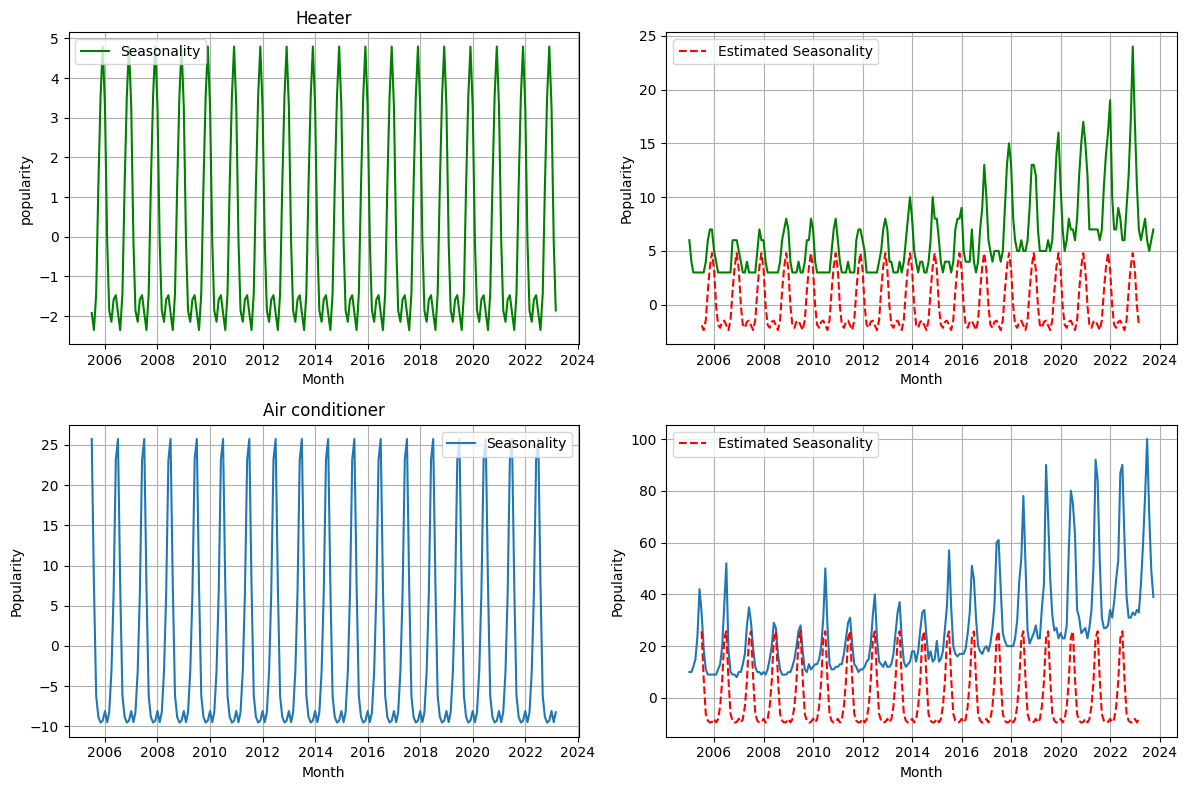

In [ ]:
# Plotting Seasonality
fig, axes = plt.subplots(2,2, figsize=(12,8))
axes[0,0].plot(df['Month'][q:n-q-1], s_k_h[q:n-q-1], color='green', label='Seasonality')
axes[0,0].set_title('Heater')
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('popularity')
axes[0,0].grid()
axes[0,0].legend()

axes[0,1].plot(df['Month'], df['Heater'], color='green')
axes[0,1].plot(df['Month'][q:n-q-1], s_k_h[q:n-q-1], color='red', linestyle='--', label= 'Estimated Seasonality')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Popularity')
axes[0,1].grid()
axes[0,1].legend()

axes[1,0].plot(df['Month'][q:n-q-1], s_k_ac[q:n-q-1], label='Seasonality')
axes[1,0].set_title('Air conditioner')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Popularity')
axes[1,0].grid()
axes[1,0].legend()

axes[1,1].plot(df['Month'], df['Air conditioner'])
axes[1,1].plot(df['Month'][q:n-q-1], s_k_ac[q:n-q-1], color='red', linestyle='--', label= 'Estimated Seasonality')
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Popularity')
axes[1,1].grid()
axes[1,1].legend()

plt.tight_layout()
plt.show()

Removing Seasonality and Trend

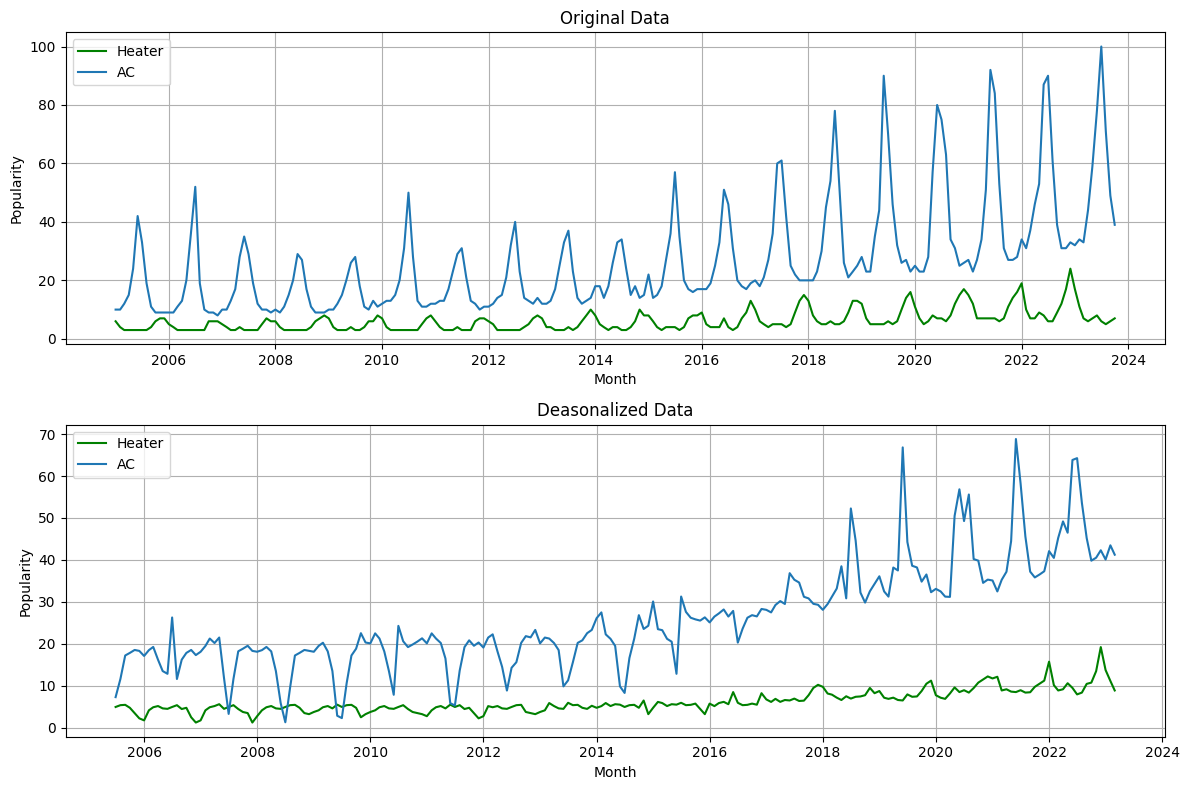

In [ ]:
# Deseasonalized data
y_tilde_h = df['Heater'] - s_k_h
y_tilde_ac = df['Air conditioner'] - s_k_ac

# Plotting Deseasonalized data
fig, axes = plt.subplots(2,1, figsize=(12,8))
axes[0].plot(df['Month'], df['Heater'], color='green', label = 'Heater')
axes[0].plot(df['Month'], df['Air conditioner'], label = 'AC')
axes[0].set_title('Original Data')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Popularity')
axes[0].legend()
axes[0].grid()

axes[1].plot(df['Month'][q:n-q-1], y_tilde_h[q:n-q-1], label='Heater', color='green')
axes[1].plot(df['Month'][q:n-q-1], y_tilde_ac[q:n-q-1], label='AC')
axes[1].set_title('Deasonalized Data')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Popularity')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

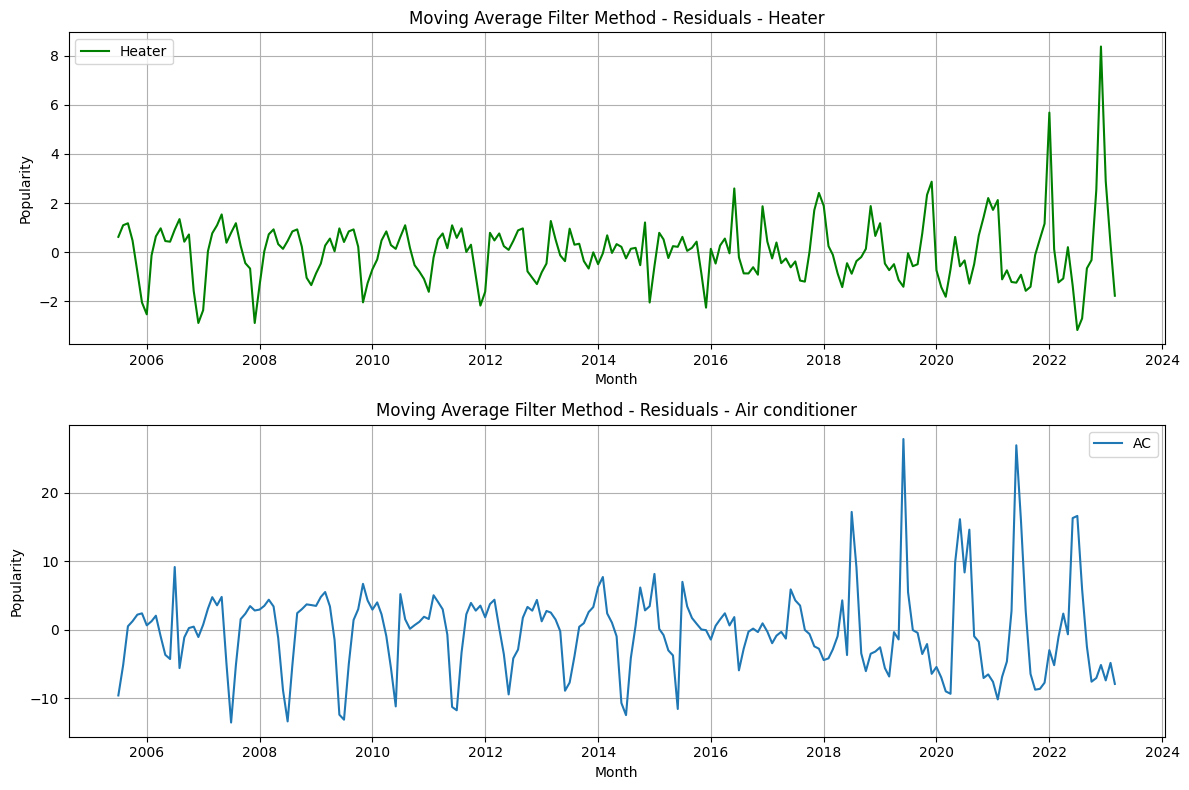

In [ ]:
# Removing Trend and Seasonality
y_tilde_t_h = y_tilde_h - m_k_h
y_tilde_t_ac = y_tilde_ac - m_k_ac

# Plotting Residuals data
fig, axes = plt.subplots(2,1, figsize=(12,8))
axes[0].plot(df['Month'][q:n-q-1], y_tilde_t_h[q:n-q-1], label='Heater', color='green')
axes[0].set_title('Moving Average Filter Method - Residuals - Heater')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Popularity')
axes[0].legend()
axes[0].grid()

axes[1].plot(df['Month'][q:n-q-1], y_tilde_t_ac[q:n-q-1], label='AC')
axes[1].set_title('Moving Average Filter Method - Residuals - Air conditioner')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Popularity')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

Stationarity Check

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf_test_h = adfuller(y_tilde_t_h[q:n-q-1])
adf_test_ac = adfuller(y_tilde_t_ac[q:n-q-1])
print("p-value of Heater: ", adf_test_h[1])
print("p-value of Air conditioner: ", adf_test_ac[1])
print("Since the p-value is less than 0.05, Hence it is stationary")

p-value of Heater:  9.194944200159672e-11
p-value of Air conditioner:  4.0614702227228675e-13
Since the p-value is less than 0.05, Hence it is stationary


Correlogram analysis

In [ ]:
# AutoCorrelation Function
def acf(dt, tc, lag):
    """
    Function to calculate auto-correlation coefficient of given lag

    Parameters
    ----------
    - dt (pd.DataFrame): The dataset used for processing
    - tc (string): Name of the Target Column
    - lag (int): Given lag

    Returns
    -------
    - (int): Computed Auto-correlation coefficient

    """
    n = len(dt)
    d1 = dt[tc]
    mean_data = np.mean(dt[tc])
    acf_value = sum(
        (d1[:n - lag] - mean_data).reset_index(drop=True) * (d1[lag:] - mean_data).reset_index(drop=True)) / sum(
        (d1 - mean_data).reset_index(drop=True) ** 2)
    return acf_value

In [ ]:
df_residual_h = pd.DataFrame(y_tilde_t_h)
df_residual_h.columns = ['Heater']
df_residual_h['Month'] = df['Month']
df_residual_ac = pd.DataFrame(y_tilde_t_ac)
df_residual_ac.columns = ['Air conditioner']
df_residual_ac['Month'] = df['Month']

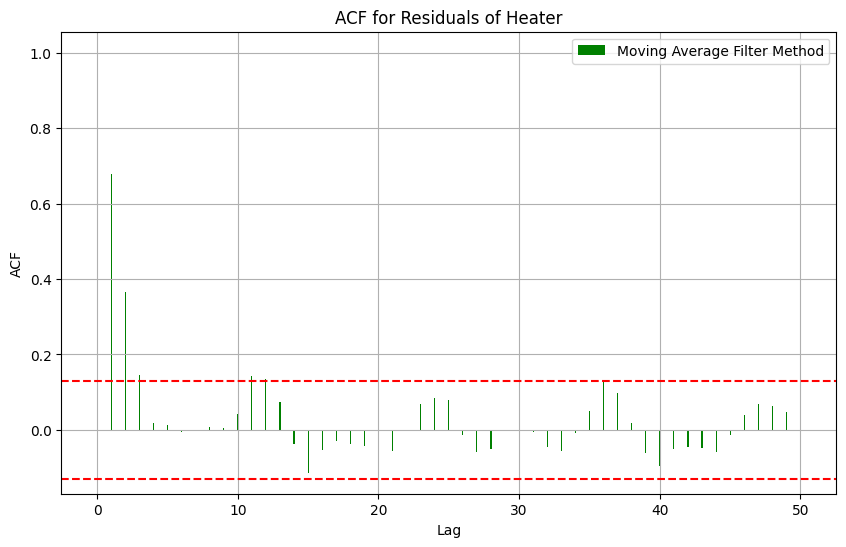

In [ ]:
# Plotting ACF of residuals of Heaters
fig = plt.figure(figsize=(10,6))
plt.title('ACF for Residuals of Heater')
plt.bar([i for i in range(0,51)],[acf(df_residual_h, 'Heater', i) for i in range(0,51)], width = 0.08, color = 'green', label = 'Moving Average Filter Method')
plt.axhline(y = 1.96/(len(df_residual_h)**0.5), color = 'r', linestyle = '--')
plt.axhline(y = -1.96/(len(df_residual_h)**0.5), color = 'r', linestyle = '--')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid()
plt.legend()
plt.show()

There seems to be no visible periodicity in the plot. ACF at h = 1, 2 are the only significant lags while the rest are zero , suggesting that the underlying is most likely to be a moving average of order 2.

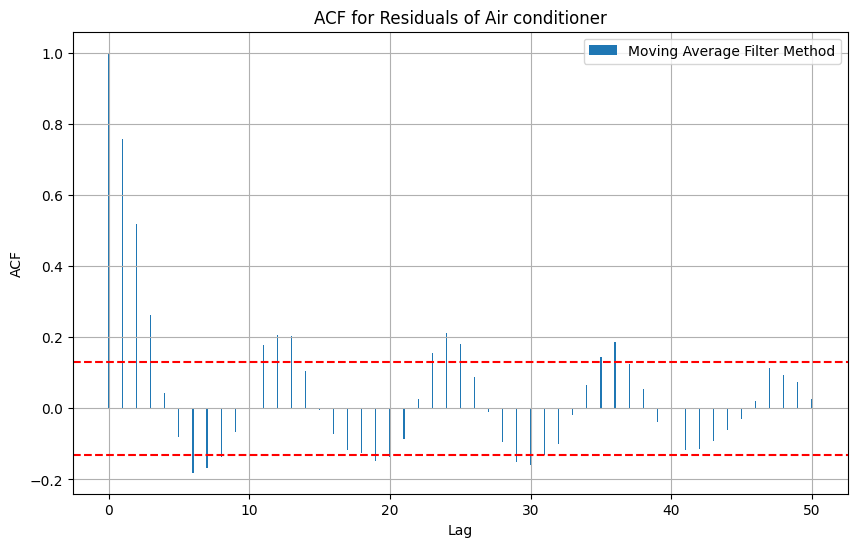

In [ ]:
# Plotting ACF of residuals of AC
fig = plt.figure(figsize=(10,6))
plt.title('ACF for Residuals of Air conditioner')
plt.bar([i for i in range(0,51)],[acf(df_residual_ac, 'Air conditioner', i) for i in range(0,51)], width = 0.08, label = 'Moving Average Filter Method')
plt.axhline(y = 1.96/(len(df_residual_ac)**0.5), color = 'r', linestyle = '--')
plt.axhline(y = -1.96/(len(df_residual_ac)**0.5), color = 'r', linestyle = '--')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid()
plt.legend()
plt.show()

there seems to be a periodic pattern in the ACF plot of residuals for AC which suggests that there might be a seasonality or a repetitive structure in the residual data. Thus the residuals might not be stationary.

#### Non-Parametric: Difference Method

Removing Trend and Seasonal Components

In [ ]:
# Heaters
df1 = df.copy()
residual_h = df.copy()
residual_h = residual_h[12:]
residual_h.drop(['Air conditioner'],axis=1,inplace=True)
df1['Heater'] = df1['Heater'].shift(d)
residual_h['Heater'] = df['Heater'][d:] - df1['Heater'][d:]

# AC
df2 = df.copy()
residual_ac = df.copy()
residual_ac = residual_ac[12:]
residual_ac.drop(['Heater'],axis=1,inplace=True)
df2['Air conditioner'] = df2['Air conditioner'].shift(d)
residual_ac['Air conditioner'] = df['Air conditioner'][d:] - df2['Air conditioner'][d:]

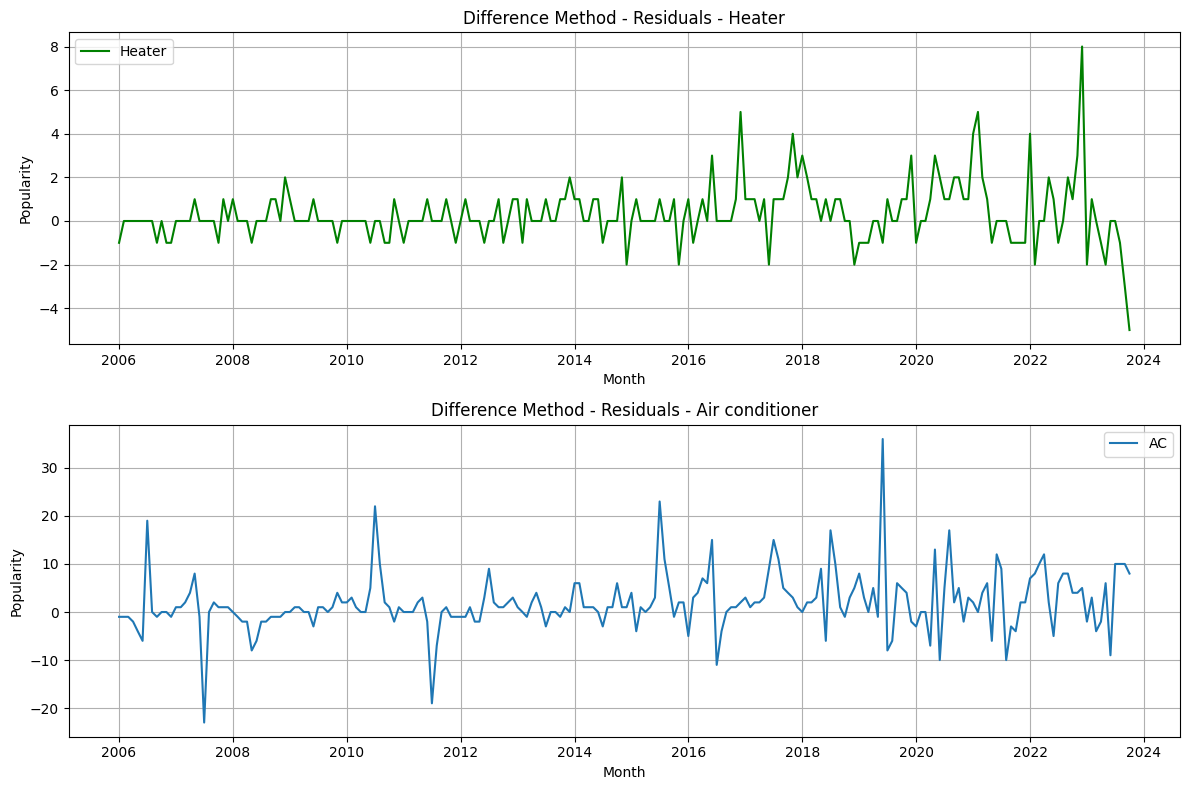

In [ ]:
# Plotting Residuals data obtained from difference method
fig, axes = plt.subplots(2,1, figsize=(12,8))
axes[0].plot(df['Month'][d:], residual_h['Heater'], label='Heater', color='green')
axes[0].set_title('Difference Method - Residuals - Heater')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Popularity')
axes[0].legend()
axes[0].grid()

axes[1].plot(df['Month'][d:], residual_ac['Air conditioner'], label='AC')
axes[1].set_title('Difference Method - Residuals - Air conditioner')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Popularity')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

Stationarity check

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf_test_h = adfuller(residual_h['Heater'])
adf_test_ac = adfuller(residual_ac['Air conditioner'])
print("p-value of Heater: ", adf_test_h[1])
print("p-value of Air conditioner: ", adf_test_ac[1])
print("Since the p-value is less than 0.05 for both heater & ac, Hence it is stationary")

p-value of Heater:  9.064201076692845e-05
p-value of Air conditioner:  0.013655828612908292
Since the p-value is less than 0.05 for both heater & ac, Hence it is stationary


Correlogram Analysis

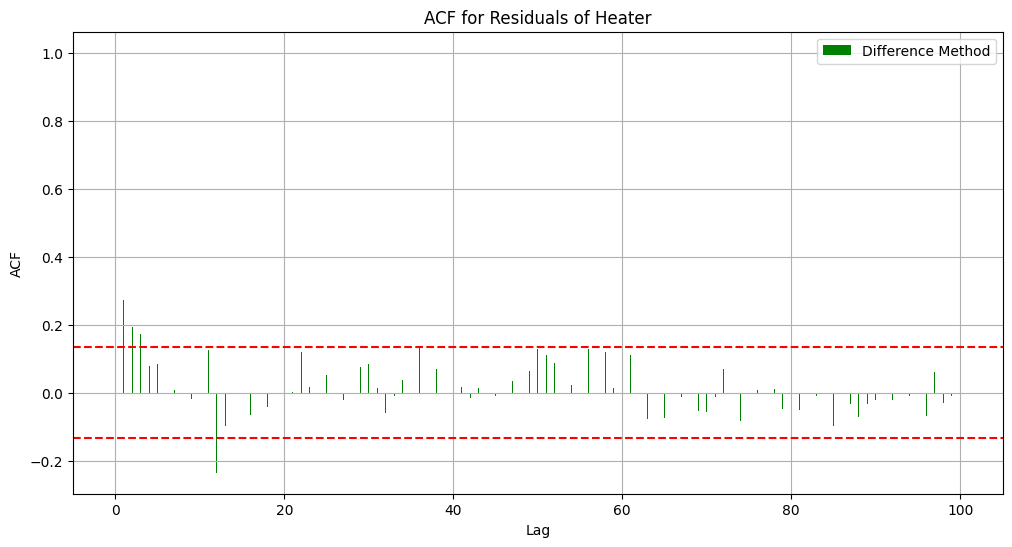

In [ ]:
# Plotting ACF of residuals of Heaters
fig = plt.figure(figsize=(12,6))
plt.title('ACF for Residuals of Heater')
plt.bar([i for i in range(0,101)],[acf(residual_h, 'Heater', i) for i in range(0,101)], width = 0.08, color = 'green', label = 'Difference Method')
plt.axhline(y = 1.96/(len(residual_h)**0.5), color = 'r', linestyle = '--')
plt.axhline(y = -1.96/(len(residual_h)**0.5), color = 'r', linestyle = '--')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid()
plt.legend()
plt.show()

Process is most likely stationary. The underlying process can be a moving average process of order 2 or 3

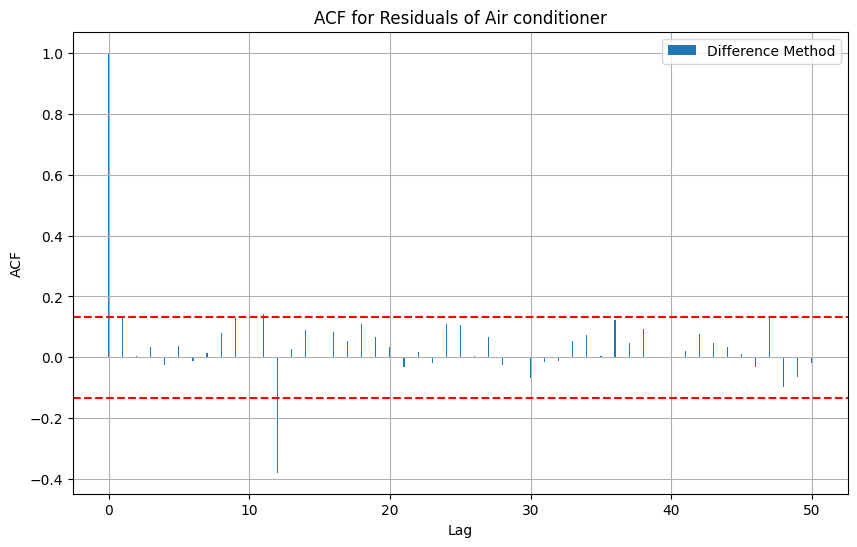

In [ ]:
# Plotting ACF of residuals of AC
fig = plt.figure(figsize=(10,6))
plt.title('ACF for Residuals of Air conditioner')
plt.bar([i for i in range(0,51)],[acf(residual_ac, 'Air conditioner', i) for i in range(0,51)], width = 0.08, label = 'Difference Method')
plt.axhline(y = 1.96/(len(residual_ac)**0.5), color = 'r', linestyle = '--')
plt.axhline(y = -1.96/(len(residual_ac)**0.5), color = 'r', linestyle = '--')
plt.grid()
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.legend()
plt.show()

Process is most likely stationary. The underlying process might be white noise

Non parametric Fitting

In [ ]:
# Fitting
# combining residuals from difference method and estimated trend and seasonality from moving average filter method

# Heaters
df_trend_h = m_k_h[d:n-q]
df_seasonality_h = s_k_h[d:n-q]
df_residual_h= residual_h['Heater'][:n-d-q]

Y_fit_h = df_trend_h + df_seasonality_h + df_residual_h

# AC
df_trend_ac = m_k_ac[d:n-q]
df_seasonality_ac = s_k_ac[d:n-q]
df_residual_ac= residual_ac['Air conditioner'][:n-d-q]

Y_fit_ac = df_trend_ac + df_seasonality_ac + df_residual_ac

In [ ]:
# RMSE for Heaters
mse_h = np.mean((df['Heater'][d:n-q] - Y_fit_h)**2)
rmse_h = np.sqrt(mse_h)
print('RMSE for heater: ', rmse_h.round(2))

# adjusted r2 for Heaters
r2_h = 1 - (sum((df['Heater'][d:n-q] - Y_fit_h)**2)/sum((df['Heater'][d:n-q] - np.mean(df['Heater'][d:n-q]))**2))
adj_r2_h = 1 - (1-r2_h)*(n-q-1)/(n-q-d-1)
print('Adjusted R2 for heater: ', adj_r2_h)

# RMSE for AC
mse_ac = np.mean((df['Air conditioner'][d:n-q] - Y_fit_ac)**2)
rmse_ac = np.sqrt(mse_ac)
print('RMSE for AC: ', rmse_ac.round(2))

# adjusted r2 for AC
r2_ac = 1 - (sum((df['Air conditioner'][d:n-q] - Y_fit_ac)**2)/sum((df['Air conditioner'][d:n-q] - np.mean(df['Air conditioner'][d:n-q]))**2))
adj_r2_ac = 1 - (1-r2_ac)*(n-q-1)/(n-q-d-1)
print('Adjusted R2 for AC: ', adj_r2_ac)

RMSE for heater:  1.29
Adjusted R2 for heater:  0.8654975880053856
RMSE for AC:  6.55
Adjusted R2 for AC:  0.8486259486789128


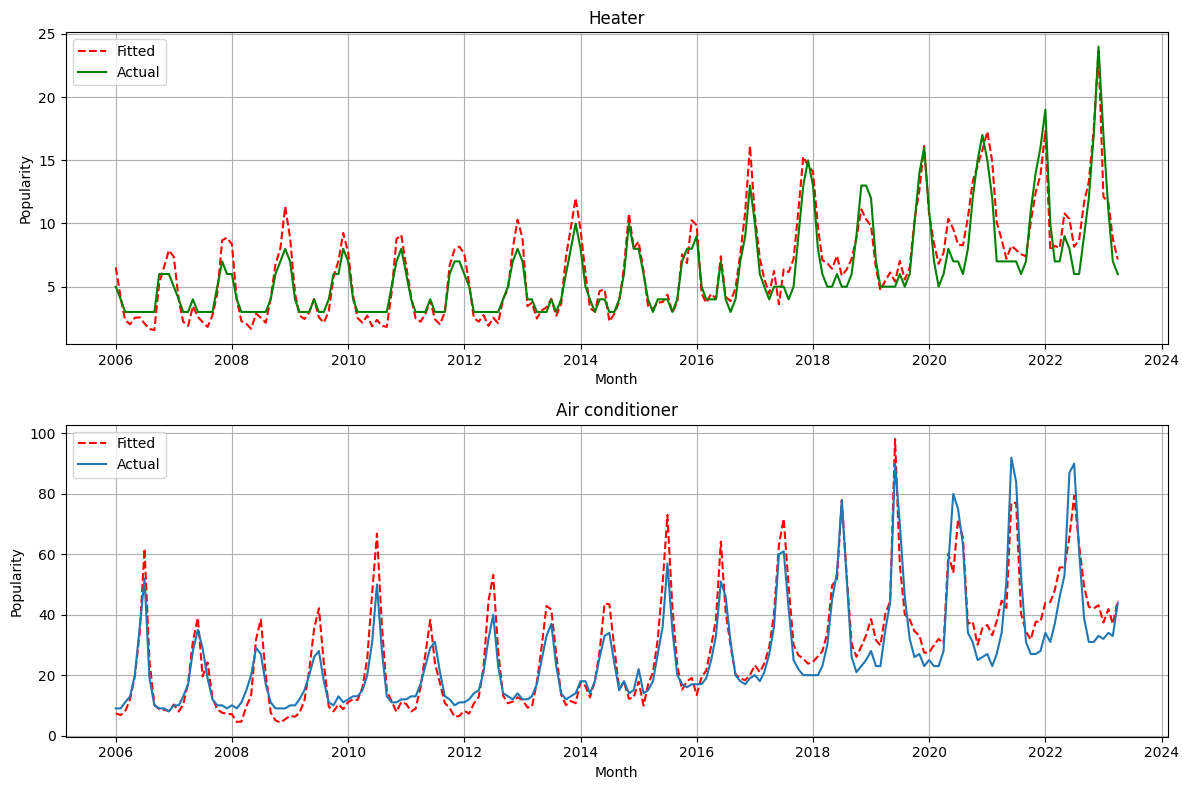

In [ ]:
# Plotting the fit with original data for both heater and ac
fig, axes = plt.subplots(2,1, figsize=(12,8))
axes[0].plot(df['Month'][d:n-q], Y_fit_h, label='Fitted', color='red', linestyle='--')
axes[0].plot(df['Month'][d:n-q], df['Heater'][d:n-q], label='Actual', color='green')
axes[0].set_title('Heater')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Popularity')
axes[0].legend()
axes[0].grid()

axes[1].plot(df['Month'][d:n-q], Y_fit_ac, label='Fitted', color='red', linestyle='--')
axes[1].plot(df['Month'][d:n-q], df['Air conditioner'][d:n-q], label='Actual')
axes[1].set_title('Air conditioner')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Popularity')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()